1. Eliminate small blobs, does not eliminate blobs with high compactness value
2. Collect typical blob by local blob matching
3. Collect false typical blob by matching blobs with blobs far away in the same section 
    - Set a cut off radius and compare this blob with all the blobs outside this radius on the same section
    - Collect the best matched pair. Or alternatively, randomly sample the outside blob and form a pair
4. Run over the entire brain
    - No need in the first trail,where we just need to get a large enough region. Let's look at the whole image first. 
5. Train the average perceptron with the same features
6. Train the average perceptron with more features


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


Cannot import mxnet.
Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [2]:
scan_parameters = {}

In [18]:
scan_parameters['stack'] = 'MD589'
scan_parameters['patch_size'] = 448
scan_parameters['patch_half_size'] = scan_parameters['patch_size']/2
scan_parameters['stride'] = 112

scan_parameters['section_limits'] = metadata_cache['section_limits'][scan_parameters['stack']]
scan_parameters['o_crop'] = True
scan_parameters['o_clear_border'] = True
scan_parameters['o_relabel'] = True
scan_parameters['oriImL1'], scan_parameters['oriImL0'] = metadata_cache['image_shape'][scan_parameters['stack']]
scan_parameters['scan_section_range'] = 1

scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','perimeter','compactness','label','major_axis_length','minor_axis_length']
scan_parameters['prop_for_comparison'] = ['area', 'eccentricity']
if 'moments_hu' in scan_parameters['prop_for_comparison']:
    scan_parameters['compare_weight'] = [1 for i in range(6 + len(scan_parameters['prop_for_comparison']))]
else:
    scan_parameters['compare_weight'] = [1 for i in range(len(scan_parameters['prop_for_comparison']))]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))
scan_parameters['similarity_threshold'] = 0.8
scan_parameters['o_fix_scan_size'] = True
scan_parameters['scan_size'] = 112
scan_parameters['scan_size_coeff'] = 5
scan_parameters['builtInProps'] = ['centroid','orientation', 'eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','label','local_centroid','major_axis_length','solidity','minor_axis_length','perimeter','solidity']
scan_parameters['prop_to_save'] = ['coords','moments_hu','centroid','area','eccentricity','equivalent_diameter']
scan_parameters['scan_outside_margin'] = 100
stack = scan_parameters['stack']

In [5]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
structure_name = '7N'
vertice_7N_dic = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()}
sectionList_7N = np.sort(vertice_7N_dic.keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


In [15]:
margin = 500
bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
# bbox_7N = bboxs_7N[154]
scan_parameters['crop_range_mmxx'] = bbox_7N
scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

In [16]:
# loading data
image = {}
stack = scan_parameters['stack']
section_begin, section_end = scan_parameters['section_limits']
# secList = range(section_begin, section_end+1)
# tempSecList = range(section_begin, section_end+1)
secList = list(sectionList_7N[0:20])
tempSecList = list(sectionList_7N[0:20])
for tempSec in tempSecList:
    try:
        image[tempSec] = fun_crop_images(DataManager.load_image_v2(stack=stack, section=tempSec, version='jpeg', prep_id=2),*scan_parameters['crop_range_mmxx'],im0max=scan_parameters['oriImL0'],im1max=scan_parameters['oriImL1'] )
    except:
        sys.stderr.write('Invalid section %d...\n'%tempSec)
        secList.remove(tempSec)
        continue
#     if os.path.isfile(img_filename[tempSec]):
#         sys.stderr.write('Image file is already available. \n')
#         continue
#     else:
#         try:
#             download_from_s3(img_filename[tempSec])
#         except:
#             sys.stderr.write('Download fail. Skip this file for section %d...\n'%tempSec)
#             secList.remove(tempSec)
#             continue   
scan_parameters['secList'] = secList

/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (185246720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [20]:
scan_range = scan_parameters['scan_section_range']
im0max = scan_parameters['im0max']
im1max = scan_parameters['im1max']
prop = scan_parameters['prop']
prop_for_comparison = scan_parameters['prop_for_comparison']
compare_weight = scan_parameters['compare_weight']
o_simil_threshold = scan_parameters['similarity_threshold']
o_fix_scan_size = scan_parameters['o_fix_scan_size']
o_scan_size_coeff = scan_parameters['scan_size_coeff']
o_scan_size = scan_parameters['scan_size']  
secList = scan_parameters['secList'] 
stack = scan_parameters['stack']

data_typical_blobs = {}
data_matched_paris = {}
data_false_typical_blobs = {}
data_false_matched_pairs = {}
data_blob_prop_dic = {}
data_blob_idx_selection = {}
# section = 154
for section in secList:
    typical_blobs = []
    matched_paris = []
    false_typical_blobs = []
    false_matched_paris = []
    cell_centroids = {}
    cell_numbers = {}
    cell_global_coord = {}
    im_blob_prop = {}
    im_label_ori = {}
    im_label = {}
    im_BW = {}
    sec_load_data_list = range(section - scan_range, section + scan_range + 1)
    scan_section = list(sec_load_data_list)
    scan_section.remove(section)
### loading data and reconstructed labeled images ###
    tempList = list(sec_load_data_list)
    for tempSec in tempList:
#         print('process section %d'%tempSec)
        if tempSec in secList:
            cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
#             print('load section %d'%tempSec)
            temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= scan_parameters['crop_range_mxmx'], 
                                                                        oriImL0=scan_parameters['oriImL0'],oriImL1=scan_parameters['oriImL1'])
            im_label[tempSec] = temp_im_label
            im_BW[tempSec] = temp_im_label > 0
            im_blob_prop[tempSec] = np.array(temp_im_blob_prop)
        else:
            sys.stderr.write('Warning: missing section %d'%tempSec)
#             print(scan_section)
            scan_section.remove(tempSec)
#             print(scan_section)
#             print(sec_load_data_list)
            sec_load_data_list.remove(tempSec)
#             print(sec_load_data_list)
            
### Start getting region properties of each blob    ###
    blob_prop_dic = fun_regionprops_dic(im_blob_prop=im_blob_prop,scan_parameters=scan_parameters)
    data_blob_prop_dic[section] = blob_prop_dic[section] # Save data
    # Eliminating too large and too small blobs
    blob_idx_selection = {tempSec : np.logical_and.reduce(np.row_stack(
        (blob_prop_dic[tempSec]['compactness']>0,
    #      blob_prop_dic[tempSec]['compactness']<2.5,
         blob_prop_dic[tempSec]['area']<3000,
         blob_prop_dic[tempSec]['area']>200))) for tempSec in sec_load_data_list}  
    
    data_blob_idx_selection[section] = blob_idx_selection[section] # Save data
    
    n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}
    secList_in_BlobPropDic = im_blob_prop.keys()
    if set(scan_section).issubset(set(secList_in_BlobPropDic)):
        pass
    else:
        print('Warrning: Scaned section(s) not included in input im_blob_prop')

        
        
### Start scanning ###
    for blobID in range(n_blobs[section]):
        if (blobID % 1000 == 0):
            print('Section %d Finished percentage: %f'%(section, (float(blobID)*100 / n_blobs[section]) ))
        
        if not blob_idx_selection[section][blobID]:
#             print('Blob %d eliminated'%blobID)  # If not the selected blob, skip the following steps
            continue
        
        temp_curr_blob_props = {}
        for tempProp in prop:
            temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][blobID]
        # Get the scan region bouding box
        tempB1_idx_loc = temp_curr_blob_props['centroid']
        if o_fix_scan_size:
            temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
            temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
        else:
            temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
            temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)


        for tempSec in scan_section:
    #         print('Blbo %d left. Start scanning'%blobID)
            if tempSec not in secList_in_BlobPropDic:
                continue

            # Find blobs at the nearby location in the scaned section
            # Method 1
            tempBlobInside = fun_blobs_in_polygen(blob_prop_dic[tempSec]['centroid'],temp_next_sec_range,coor_order='cr')
#             tempBlobOutside = fun_blobs_out_polygen(blob_prop_dic[tempSec]['centroid'], temp_next_sec_range, coor_order='cr', margin=scan_parameters['scan_outside_margin'])
                # Use the annotated boundary
            tempBlobOutside = fun_blobs_out_polygen(blob_prop_dic[tempSec]['centroid'], vertice_7N_dic[tempSec], coor_order='rc', margin=scan_parameters['scan_outside_margin'])
    #         tempPath = matplotlib.path.Path(temp_next_sec_range)
    #         tempBlobInside = tempPath.contains_points(blob_prop_dic[tempSec]['centroid'])
            tempBlobInsideIndex = np.where(tempBlobInside)[0]
            temp_num_blob = len(tempBlobInsideIndex)
            tempBlobOutsideIndex = np.where(tempBlobOutside)[0]
            temp_num_outblob = len(tempBlobOutsideIndex)

            if temp_num_blob:
                temp_sim = {}
                for temp_prop in prop_for_comparison:
                          temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
                temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

                #### Blob comparison ####
                temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
                temp_compare_result = temp_weighted_sim > o_simil_threshold
                if any(temp_compare_result.tolist()):
    #                 print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                    typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                    matched_paris.append([section,blobID,
                                          im_blob_prop[section][blobID],
                                          tempSec, 
                                          tempBlobInsideIndex[temp_compare_result], 
                                          im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],
                                          temp_sim_matrix[temp_compare_result,:]])
    #             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
            else:
    #             print('No blobs found in this section')
                pass


            if temp_num_outblob:
                temp_false_sim = {}
                for temp_prop in prop_for_comparison:
                          temp_false_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobOutside],distance_type=temp_prop))
                temp_false_sim_matrix = np.column_stack((temp_false_sim[temp_prop] for temp_prop in prop_for_comparison))

                #### Blob comparison ####
                temp_weighted_false_sim = np.dot(temp_false_sim_matrix,compare_weight)
                temp_false_compare_result = temp_weighted_false_sim > o_simil_threshold
                if any(temp_false_compare_result.tolist()):
    #                 print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                    false_typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                    false_matched_paris.append([section,blobID,im_blob_prop[section][blobID],
                                                tempSec, 
                                                tempBlobOutsideIndex[temp_false_compare_result], 
                                                im_blob_prop[tempSec][tempBlobOutsideIndex[temp_false_compare_result]],
                                                temp_false_sim_matrix[temp_false_compare_result,:]])
    #             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
            else:
    #             print('No blobs found in this section')
                pass
    data_typical_blobs[section] = typical_blobs
    data_matched_paris[section] = matched_paris
    data_false_typical_blobs[section] = false_typical_blobs
    data_false_matched_pairs[section] = false_matched_paris   

Section 152 Finished percentage: 0.000000
Section 152 Finished percentage: 42.863266
Section 152 Finished percentage: 85.726532
Section 153 Finished percentage: 0.000000
Section 153 Finished percentage: 57.372347
Section 154 Finished percentage: 0.000000
Section 154 Finished percentage: 45.977011
Section 154 Finished percentage: 91.954023
Section 155 Finished percentage: 0.000000
Section 155 Finished percentage: 37.965072
Section 155 Finished percentage: 75.930144
Section 156 Finished percentage: 0.000000
Section 156 Finished percentage: 59.630292
Section 157 Finished percentage: 0.000000
Section 157 Finished percentage: 40.241449
Section 157 Finished percentage: 80.482897
Section 158 Finished percentage: 0.000000
Section 158 Finished percentage: 55.586437
Section 159 Finished percentage: 0.000000
Section 159 Finished percentage: 38.744673
Section 159 Finished percentage: 77.489345
Section 160 Finished percentage: 0.000000
Section 160 Finished percentage: 36.523009
Section 160 Finished

Section 171 Finished percentage: 0.000000
Section 171 Finished percentage: 26.645350
Section 171 Finished percentage: 53.290701
Section 171 Finished percentage: 79.936051


# Construct training samples

In [73]:
def fun_get_regionprops(skimage_measure_region, prop):
    buildinProps = ['centroid','orientation', 'eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','label','local_centroid','major_axis_length','solidity','minor_axis_length','perimeter','solidity']
    PI = 3.1415926
    if type(skimage_measure_region) in [list, tuple]:
#         print(type(skimage_measure_region))
        num_region = len(skimage_measure_region)
        if prop in buildinProps:
            return [skimage_measure_region[blobID][prop] for blobID in range(num_region)]
        elif prop == 'compactness':
            return [float(skimage_measure_region[blobID]['perimeter'])**2 / float(skimage_measure_region[blobID]['area']) / (4 * PI) for blobID in range(num_region)]
    else:
        if prop in buildinProps:
            return skimage_measure_region[prop]
        elif prop == 'compactness':
            return float(skimage_measure_region['perimeter'])**2 / float(skimage_measure_region['area']) / (4 * PI)

def fun_matched_pairs_to_regionprop_pairs(record):
    regionprop_pairs = []
    for tempRP in record[5]:
        regionprop_pairs.append([record[2], tempRP])
    return regionprop_pairs

## Positive examples

In [84]:
data_typical_blobs_properties = {}
for tempSec in data_typical_blobs.keys():
    data_typical_blobs_properties[tempSec] = [record[2] for record in data_typical_blobs[tempSec]]

data_typical_blobs_properties = fun_regionprops_dic(data_typical_blobs_properties, scan_parameters)
data_typical_blobs_properties_flatten = {}
# typical_blob_properties, might be dubplicated due to multiple sections matching
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_flatten[tempProp] = np.concatenate(tuple([data_typical_blobs_properties[tempSec][tempProp] for tempSec in data_typical_blobs_properties.keys()]))
# dd for delete-duplicated
data_typical_blobs_properties_dd = {}
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_dd[tempProp] =  np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp][np.unique(data_typical_blobs_properties[tempSec]['label'])-1] for tempSec in data_blob_prop_dic.keys()]))
# All detected blob properties in the cropped region
data_blob_prop_dic_flatten = {}
data_selected_blob_props_flatten_dic = {}
for tempProp in scan_parameters['prop']:
    data_blob_prop_dic_flatten[tempProp] = np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp] for tempSec in data_blob_prop_dic.keys()]))
# All the selected blob properties in the cropped region
temp_selected_idx_flatten = np.logical_and(data_blob_prop_dic_flatten['area']>200, data_blob_prop_dic_flatten['area']<3000)
for tempProp in scan_parameters['prop']:
    data_selected_blob_props_flatten_dic[tempProp] = data_blob_prop_dic_flatten[tempProp][temp_selected_idx_flatten]

In [97]:
tempStructure = '7N'
typical_blob_idx_7N = {tempSec : np.where(fun_blobs_in_polygen(data_typical_blobs_properties[tempSec]['centroid'], 
                                                  vertice_7N_dic[tempSec], 
                                                  crop_min_list=[scan_parameters['crop_0_min'], scan_parameters['crop_1_min']]))[0] 
                   for tempSec in data_typical_blobs_properties.keys()}

In [121]:
# Construct the regionprops for positive examples
data_matched_regionprop_pairs = {}
for tempSec in data_matched_paris.keys():
    data_matched_regionprop_pairs[tempSec] = []
    for record in np.array(data_matched_paris[tempSec])[typical_blob_idx_7N[tempSec]]: # Select pairs that are inside 7N
        data_matched_regionprop_pairs[tempSec] = data_matched_regionprop_pairs[tempSec] + fun_matched_pairs_to_regionprop_pairs(record)

In [83]:

fun_similarity( *tuple(fun_get_regionprops(record, tempProp)), distance_type=tempProp )

array([ 0.96132218,  0.6150646 ,  0.16347117,  0.08661053,  0.00454233,
        0.11921402,  0.01985229])

In [79]:
scan_parameters['props_for_training'] = ['area', 'eccentricity', 'orientation', 'compactness', 'moments_hu']

In [127]:
positive_similarity_vec_dic = {}
for tempSec in data_matched_regionprop_pairs.keys():
    positive_similarity_vec_dic[tempSec] = {}
    for tempProp in scan_parameters['props_for_training']:
        positive_similarity_vec_dic[tempSec][tempProp] = []
        for record in data_matched_regionprop_pairs[tempSec]:
            positive_similarity_vec_dic[tempSec][tempProp].append( fun_similarity(*fun_get_regionprops(record, tempProp), distance_type=tempProp))
# Get similarity matrix of positive example for each section
positive_similarity_matrix_dic = {}
for tempSec in positive_similarity_vec_dic.keys():
    temp = []
    for tempProp in scan_parameters['props_for_training']:
        temp.append(np.array(positive_similarity_vec_dic[tempSec][tempProp]))
        positive_similarity_matrix_dic[tempSec] = np.column_stack(tuple(temp))

## Negative examples

# Analyze typical blobs  - Histograms

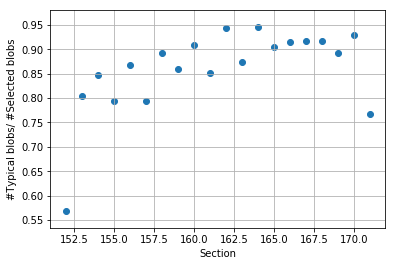

In [23]:
temp_num_typical_blob = [np.count_nonzero(np.unique(data_typical_blobs_properties[tempSec]['label'])) for tempSec in secList]
temp_num_selected_blob = [np.count_nonzero(data_blob_idx_selection[tempSec]) for tempSec in secList]
plt.scatter(np.array(secList), np.array(temp_num_typical_blob, dtype=np.float) / np.array(temp_num_selected_blob, dtype=np.float))
plt.xlabel('Section')
plt.ylabel('#Typical blobs/ #Selected blobs')
plt.grid()

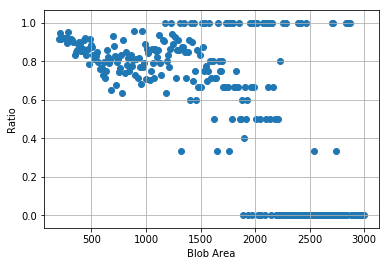

In [24]:
temp_num_bin = 281
temp1 = np.histogram(data_typical_blobs_properties_dd['area'], bins=temp_num_bin,range=(200,3000))
temp2 = np.histogram(data_selected_blob_props_flatten_dic['area'], bins=temp_num_bin,range=(200,3000))
plt.scatter(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(temp2[0] + 0.00000001))
plt.xlabel('Blob Area')
plt.ylabel('Ratio')
plt.grid()

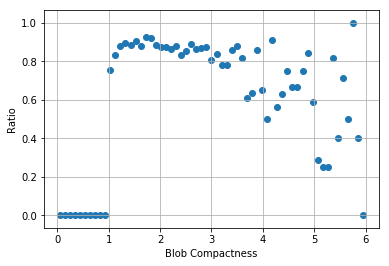

In [25]:
temp_num_bin = 61
temp_range = (0,6)
temp1 = np.histogram(data_typical_blobs_properties_dd['compactness'], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic['compactness'], bins=temp_num_bin,range=temp_range)
plt.scatter(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000000001)/(temp2[0] + 0.00000001))
plt.xlabel('Blob Compactness')
plt.ylabel('Ratio')
plt.grid()

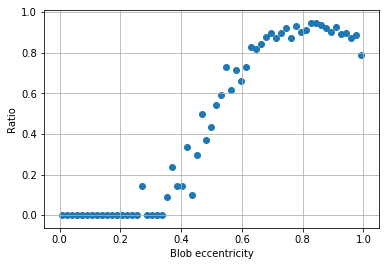

In [26]:
temp_num_bin = 61
temp_range = (0,1)
tempProp = 'eccentricity'
temp1 = np.histogram(data_typical_blobs_properties_dd[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic[tempProp], bins=temp_num_bin,range=temp_range)
plt.scatter(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000000001)/(temp2[0] + 0.00000001))
plt.xlabel('Blob ' + tempProp)
plt.ylabel('Ratio')
plt.grid()

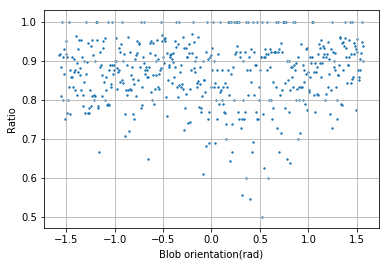

In [27]:
PI = 3.1415926
temp_num_bin = 500
temp_range = (-PI/2 ,PI/2)
tempProp = 'orientation'
temp1 = np.histogram(data_typical_blobs_properties_dd[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic[tempProp], bins=temp_num_bin,range=temp_range)
plt.scatter(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000000001)/(temp2[0] + 0.00000001),s=2)
plt.xlabel('Blob ' + tempProp+'(rad)')
plt.ylabel('Ratio')
plt.grid()